## Materialization Correctness
To ensure the materialization code is working correctly, in this notebook, we create a medium size graph with several ml models and manually check the potential, recreation cost, and |pipelines| to compare with the computed values from the materialization code.

In [1]:
# numpy and pandas for data manipulation
import sys
import os
# Suppress warnings
import warnings

import matplotlib.pyplot as plt
import networkx as nx

import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import cPickle as pickle

warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

ROOT = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/'
ROOT_PACKAGE_DIRECTORY = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/collaborative-optimizer'
root_data = ROOT + '/data'

sys.path.append(ROOT_PACKAGE_DIRECTORY)
from experiment_graph.executor import CollaborativeExecutor
from experiment_graph.workload import Workload
from experiment_graph.execution_environment import ExecutionEnvironment
from experiment_graph.benchmark_helper import BenchmarkMetrics
from experiment_graph.data_storage import DedupedStorageManager

DATABASE_PATH = root_data + '/experiment_graphs/home-credit-default-risk/materialization-test'
N_ESTIMATOR = 100

In [2]:
class MaterializationTest(Workload):
    def run(self, execution_environment, root_data):
        # Load Data
        train = execution_environment.load(root_data +
                                           '/openml/task_id=31/train.csv')
        test = execution_environment.load(root_data +
                                          '/openml/task_id=31/test.csv')

        test_labels = test['class']
        test = test.drop('class')

        train_labels = train['class']
        train = train.drop(columns=['class'])

        train2 = train.drop('checking_status')
        test2 = test.drop('checking_status')
        from experiment_graph.sklearn_helper.preprocessing import MinMaxScaler
        scaler2 = MinMaxScaler(feature_range=(0, 1))
        scaler2.fit(train2)
        train2 = scaler2.transform(train2)
        test2 = scaler2.transform(test2)

        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(train)
        train = scaler.transform(train)
        test = scaler.transform(test)
        # Random Forest 1 (n_estimator = 10)
        from experiment_graph.sklearn_helper.ensemble import RandomForestClassifier
        random_forest10 = RandomForestClassifier(
            n_estimators=10, random_state=50, verbose=1, n_jobs=-1)
        random_forest10.fit(train, train_labels)

        # Execute
        random_forest10.trained_node.data()

        print 'random_forest10: {}'.format(
            random_forest10.score(test, test_labels).data())

        # Random Forest 2 (n_estimator = 100)
        from experiment_graph.sklearn_helper.ensemble import RandomForestClassifier
        random_forest100 = RandomForestClassifier(
            n_estimators=100, random_state=50, verbose=1, n_jobs=-1)
        random_forest100.fit(train, train_labels)

        # Execute
        random_forest100.trained_node.data()

        print 'random_forest100: {}'.format(
            random_forest100.score(test, test_labels).data())

        # Logistic Regression
        from experiment_graph.sklearn_helper.linear_model import LogisticRegression

        # Make the model with the specified regularization parameter
        log_reg = LogisticRegression(C=0.0001)

        # Train on the training data
        log_reg.fit(train, train_labels)

        print 'log_reg: {}'.format(log_reg.score(test, test_labels).data())

        # Gradient Boosted 1 (n_estimator = 60)
        from experiment_graph.sklearn_helper.sklearn_wrappers import LGBMClassifier

        model60 = LGBMClassifier(
            n_estimators=60,
            objective='binary',
            class_weight='balanced',
            learning_rate=0.05,
            reg_alpha=0.1,
            reg_lambda=0.1,
            subsample=0.8,
            n_jobs=-1,
            random_state=50)

        # Train the model
        model60.fit(
            train,
            train_labels,
            custom_args={
                'eval_metric': 'accuracy',
                'verbose': 200
            })

        # Make predictions
        print 'model60: '.format(model60.score(test, test_labels).data())

        # Gradient Boosted 2 (n_estimator = 100)
        from experiment_graph.sklearn_helper.sklearn_wrappers import LGBMClassifier

        model100 = LGBMClassifier(
            n_estimators=100,
            objective='binary',
            class_weight='balanced',
            learning_rate=0.05,
            reg_alpha=0.1,
            reg_lambda=0.1,
            subsample=0.8,
            n_jobs=-1,
            random_state=50)

        # Train the model
        model100.fit(
            train,
            train_labels,
            custom_args={
                'eval_metric': 'accuracy',
                'verbose': 200
            })

        # Make predictions
        print 'model100: {}'.format(model100.score(test, test_labels).data())

        # Gradient Boosted 3 (n_estimator = 60) modified train
        from experiment_graph.sklearn_helper.sklearn_wrappers import LGBMClassifier

        model60_2 = LGBMClassifier(
            n_estimators=60,
            objective='binary',
            class_weight='balanced',
            learning_rate=0.05,
            reg_alpha=0.1,
            reg_lambda=0.1,
            subsample=0.8,
            n_jobs=-1,
            random_state=50)

        # Train the model
        model60_2.fit(
            train2,
            train_labels,
            custom_args={
                'eval_metric': 'accuracy',
                'verbose': 200
            })

        # Make predictions
        print 'model60_2: {}'.format(
            model60_2.score(test2, test_labels).data())
        return True

In [3]:
# Prepare the Data
# Create Execution Environment with AllMaterializer
ee = ExecutionEnvironment(DedupedStorageManager()) 
workload = MaterializationTest()
executor = CollaborativeExecutor(ee)
executor.end_to_end_run(workload=workload, root_data=root_data)

creating a new root node
creating a new root node


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


random_forest10: {'accuracy': 0.79000000000000004}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


random_forest100: {'accuracy': 0.76000000000000001}
log_reg: {'accuracy': 0.69999999999999996}
model60: 
model100: {'accuracy': 0.81000000000000005}
model60_2: {'accuracy': 0.78000000000000003}


True

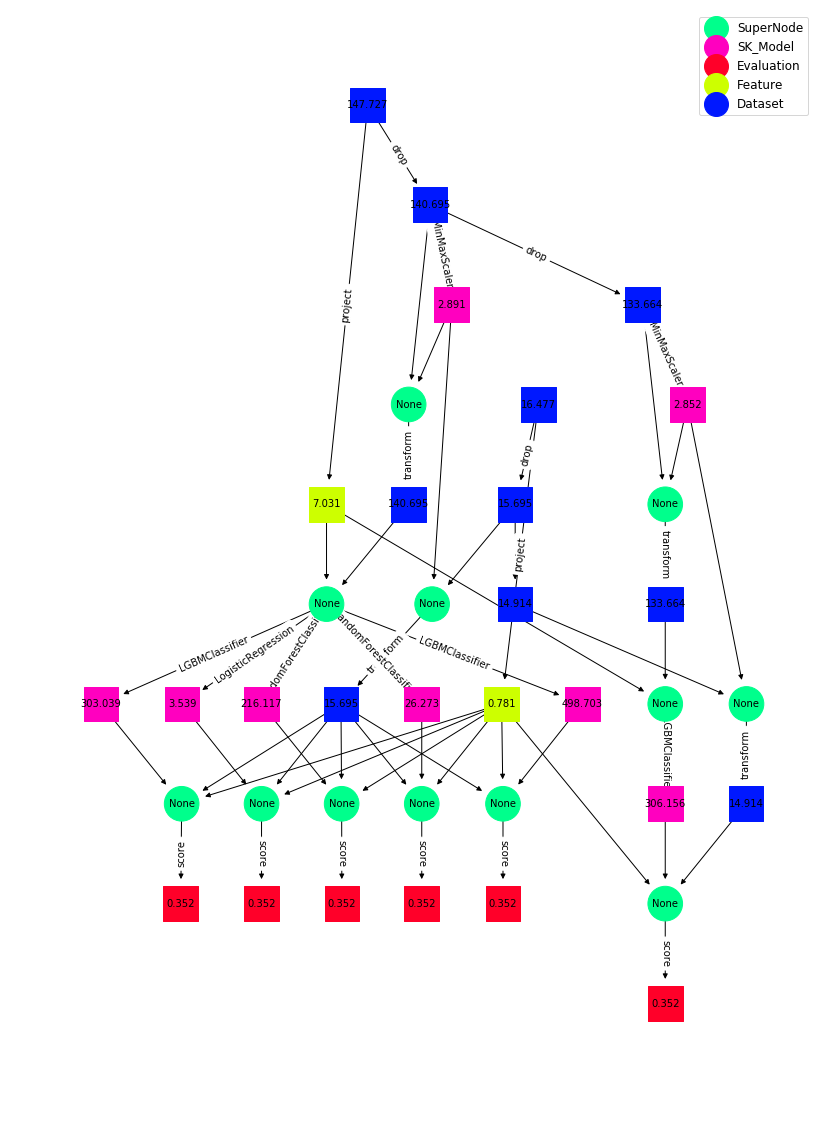

In [4]:
executor.execution_environment.experiment_graph.plot_graph(
    plt,
    figsize=(14, 20),
    labels_for_vertex=['size'],
    labels_for_edges=['name'],
    vertex_size=1200)

## Simple Based Materialization

In [5]:
from experiment_graph.materialization_algorithms.materialization_methods import HeuristicsMaterializer
budget = 1024
heuristicsMat = HeuristicsMaterializer(storage_budget=budget, modify_graph=True)

In [6]:
# Prepare the Data
# Create Execution Environment with AllMaterializer
ee = ExecutionEnvironment(DedupedStorageManager())
workload = MaterializationTest()
executor = CollaborativeExecutor(ee, heuristicsMat)
executor.end_to_end_run(workload=workload, root_data=root_data)

creating a new root node
creating a new root node


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


random_forest10: {'accuracy': 0.79000000000000004}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


random_forest100: {'accuracy': 0.76000000000000001}
log_reg: {'accuracy': 0.69999999999999996}
model60: 
model100: {'accuracy': 0.81000000000000005}
model60_2: {'accuracy': 0.78000000000000003}


True

In [7]:
graph = executor.execution_environment.experiment_graph.graph
for n,d in graph.nodes(data=True):
    if d['type'] != 'SuperNode':
        print d['mat'], d['rho'], d['type'], d['size']
        

True 0.20394027626 Evaluation 0.3515625
True 0.00194688884073 Feature 7.03125
True 0.0937868076566 Evaluation 0.3515625
True 0.000887610218507 Dataset 15.6953125
True 0.000998447309294 Dataset 14.9140625
True 0.00482959679221 SK_Model 2.8515625
False 0.000100859590589 Dataset 133.6640625
True 0.00486284169108 SK_Model 2.890625
True 0.0420917678649 Evaluation 0.3515625
True 0.0174865397796 Feature 0.78125
True inf Dataset 147.7265625
False 9.85410192145e-05 Dataset 140.6953125
True 0.000909197355088 Dataset 14.9140625
True 0.00173267867819 SK_Model 26.2734375
True 0.0775663916315 Evaluation 0.3515625
False 6.0334304758e-05 SK_Model 498.703125
True 0.000110760809921 Dataset 133.6640625
True 0.000304290817371 SK_Model 216.1171875
True 0.00376540405641 SK_Model 3.5390625
True 0.280906857726 Evaluation 0.3515625
False 8.0373234545e-05 SK_Model 303.0390625
True 0.000104414081863 Dataset 140.6953125
True 0.000110252587528 SK_Model 306.15625
True 0.000946623639895 Dataset 15.6953125
True inf D

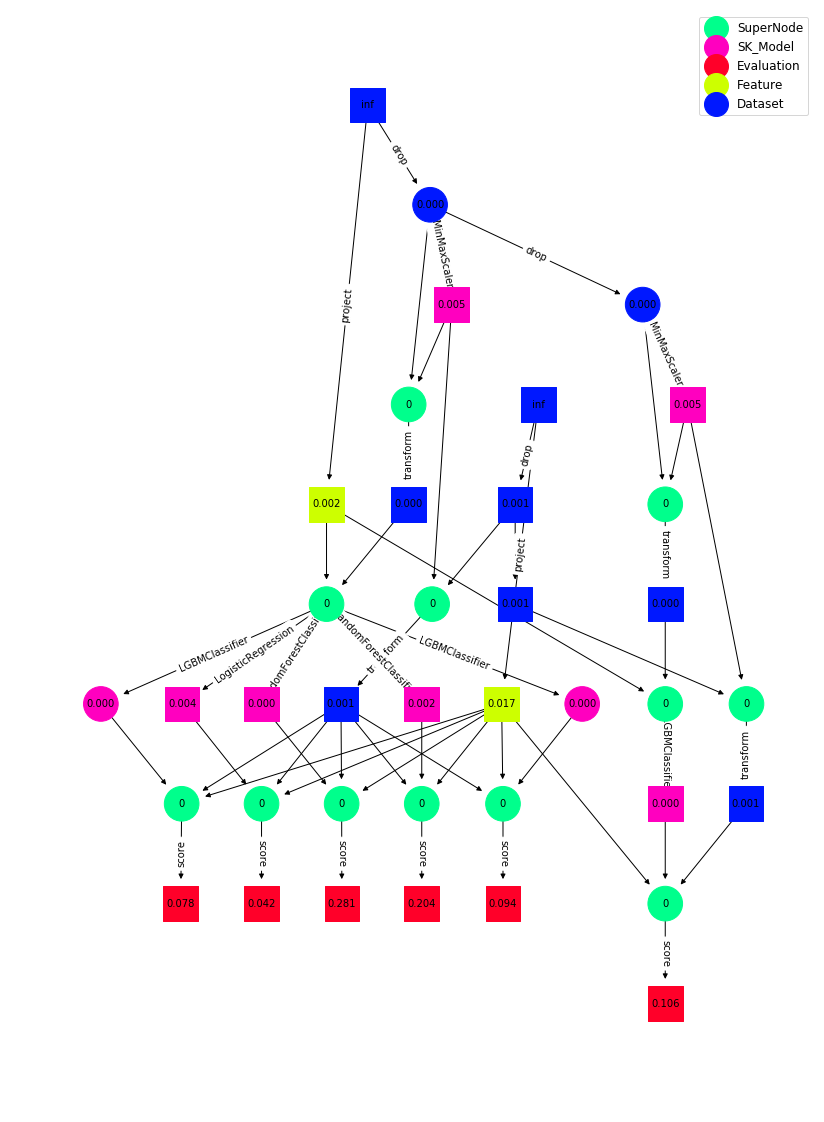

In [8]:
executor.execution_environment.experiment_graph.plot_graph(
    plt,
    figsize=(14, 20),
    labels_for_vertex=['rho'],
    labels_for_edges=['name'],
    vertex_size=1200)

In [9]:
print 'Total size of all the artifacts: {}'.format(
    executor.execution_environment.experiment_graph.get_total_size())

print 'Real size of the materialized artifacts: {}'.format(
    executor.execution_environment.experiment_graph.get_real_size())

print 'Sum of size of all the materialized artifacts: {}'.format(
    executor.execution_environment.experiment_graph.
    get_total_materialized_size())

Total size of all the artifacts: 2143.6328125
Real size of the materialized artifacts: 1005.671875
Sum of size of all the materialized artifacts: 1067.53125


## Storage Aware Materialization

In [10]:
from experiment_graph.materialization_algorithms.materialization_methods import StorageAwareMaterializer
budget = 1024
heuristicsMat = StorageAwareMaterializer(storage_budget=budget, modify_graph=True)

In [11]:
# Prepare the Data
# Create Execution Environment with AllMaterializer
ee = ExecutionEnvironment(DedupedStorageManager())
workload = MaterializationTest()
executor = CollaborativeExecutor(ee, heuristicsMat)
executor.end_to_end_run(workload=workload, root_data=root_data)

creating a new root node
creating a new root node


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


random_forest10: {'accuracy': 0.79000000000000004}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


random_forest100: {'accuracy': 0.76000000000000001}
log_reg: {'accuracy': 0.69999999999999996}
model60: 
model100: {'accuracy': 0.81000000000000005}
model60_2: {'accuracy': 0.78000000000000003}
current size: 1035.734375
current size: 1341.890625
current size: 1341.890625


True

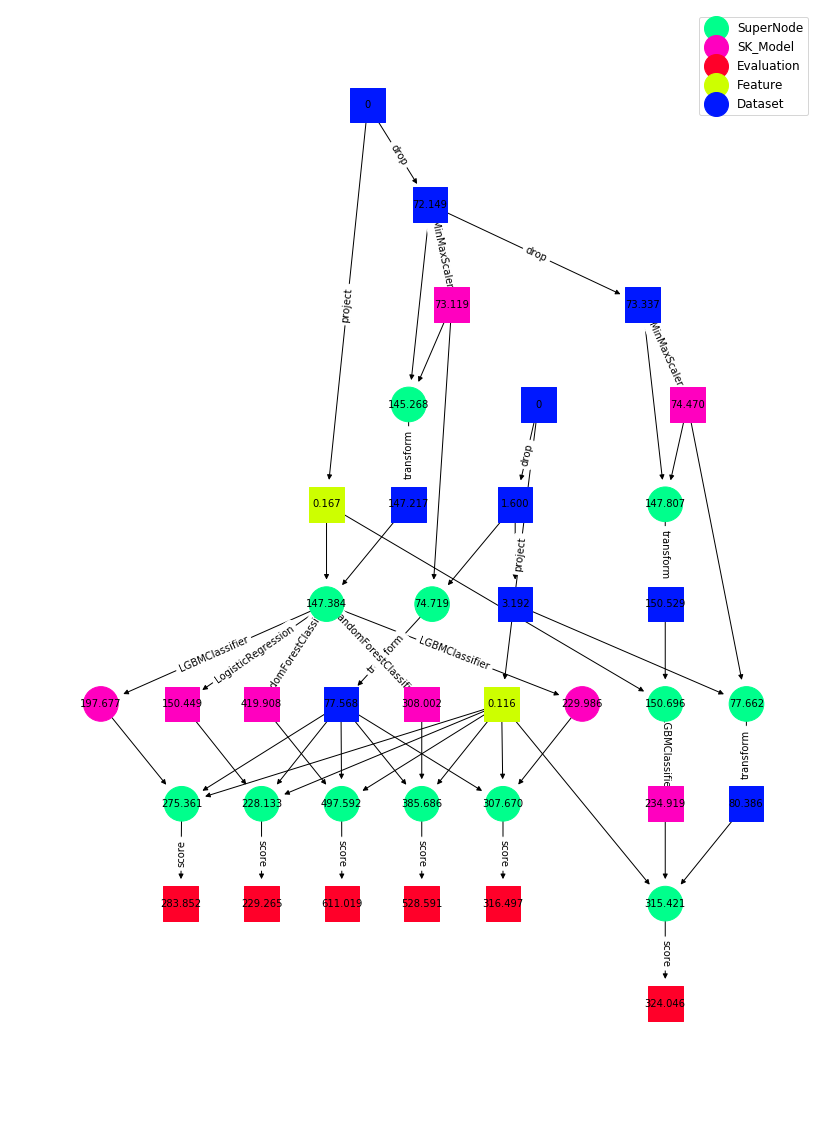

In [12]:
executor.execution_environment.experiment_graph.plot_graph(
    plt,
    figsize=(14, 20),
    labels_for_vertex=['recreation_cost'],
    labels_for_edges=['name'],
    vertex_size=1200)

In [13]:
print 'Total size of all the artifacts: {}'.format(
    executor.execution_environment.experiment_graph.get_total_size())

print 'Real size of the materialized artifacts: {}'.format(
    executor.execution_environment.experiment_graph.get_real_size())

print 'Sum of size of all the materialized artifacts: {}'.format(
    executor.execution_environment.experiment_graph.
    get_total_materialized_size())

Total size of all the artifacts: 2143.6328125
Real size of the materialized artifacts: 998.7109375
Sum of size of all the materialized artifacts: 1341.890625


In [18]:
graph = executor.execution_environment.experiment_graph.graph
for n, d in graph.nodes(data=True):
    if d['type'] != 'SuperNode':
        print d['mat'], d['rho'], d['type'], d['n_recreation_cost'], \
        d['n_potential'], d['size'], (0.5 * d['n_recreation_cost'] + 0.5 * d['n_potential'] )/d['size']

True 0.139778236758 Evaluation 0.0720008009306 0.0262807717898 0.3515625 0.139778236758
True 0.00194144165694 Feature 2.27475188859e-05 0.0272787757818 7.03125 0.00194144165694
True 0.0996366433838 Evaluation 0.0431109070948 0.0269461077844 0.3515625 0.0996366433838
True 0.000875953125574 Dataset 0.000217940300703 0.0272787757818 15.6953125 0.000875953125574
True 0.00123701026884 Dataset 0.0109495931327 0.0259481037924 14.9140625 0.00123701026884
True 0.00632843619301 SK_Model 0.0101437588709 0.0259481037924 2.8515625 0.00632843619301
True 0.00013443229622 Dataset 0.00998942989542 0.0259481037924 133.6640625 0.00013443229622
True 0.00644125601059 SK_Model 0.00995973552945 0.0272787757818 2.890625 0.00644125601059
True 0.0775332433268 Evaluation 0.0312288019004 0.0232867598137 0.3515625 0.0775332433268
True 0.0174685289303 Feature 1.5800671801e-05 0.0272787757818 0.78125 0.0174685289303
True inf Dataset 0.0 0.0272787757818 147.7265625 9.2328608072e-05
True 0.000131867879408 Dataset 0.00